In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
train_data = datasets.QMNIST(root="data" ,
                             download = True ,
                             transform = ToTensor(),
                             train = True,
                             )
test_data = datasets.QMNIST(root="data" ,
                             download = True ,
                             transform = ToTensor(),
                             train = False,)
classNames = test_data.classes
classNames
batch_size = 32
trainDataLoader  = DataLoader(dataset = train_data ,batch_size = batch_size , shuffle = True )
testDataLoader = DataLoader(dataset = test_data , batch_size = batch_size , shuffle = False)

100%|██████████| 9704059/9704059 [00:00<00:00, 96886838.91it/s]

Extracting data/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to data/QMNIST/raw


100%|██████████| 463024/463024 [00:00<00:00, 14039046.47it/s]

Extracting data/QMNIST/raw/qmnist-train-labels-idx2-int.gz to data/QMNIST/raw


100%|██████████| 9742279/9742279 [00:00<00:00, 109664768.64it/s]

Extracting data/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to data/QMNIST/raw


100%|██████████| 526800/526800 [00:00<00:00, 13471854.96it/s]

Extracting data/QMNIST/raw/qmnist-test-labels-idx2-int.gz to data/QMNIST/raw


(3, <matplotlib.image.AxesImage at 0x7a00dea03970>)

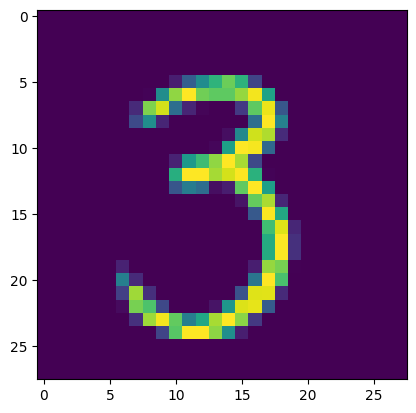

In [3]:
img , label = train_data[torch.randint(0,len(train_data) , size = [1]).item()]

label , plt.imshow(img.squeeze())


In [18]:
def train(model = None, loss_fn =None ,lr = 0.1,epochs = 3, trainDataLoader=None  , testDataLoader = None , batch_size = 32 ):
  import torch
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(device)
  model.to(device)
  optimizer = torch.optim.Adam(params = model.parameters() , lr = lr)
  from tqdm.auto import tqdm

  for epoch in tqdm(range(epochs)):
    model.train()
    iterLoss = 0
    for batch , (X,y) in enumerate(trainDataLoader):
      logits = model(X.to(device))
      loss = loss_fn(logits.to(device) , y.to(device))
      iterLoss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if(batch % 400 == 0 ): print(f"seen {batch * batch_size} / {len(trainDataLoader)*batch_size}")
    overallLoss = iterLoss / len(trainDataLoader)

    model.eval()
    with torch.inference_mode():
      testLoss = 0
      testAcc = 0
      for batch , (X , y_test) in enumerate(testDataLoader):
        test_logits = model(X.to(device))
        test_loss = loss_fn(test_logits.to(device) , y_test.to(device))
        testLoss += test_loss
        currAcc=torch.sum(y_test.to(device) == test_logits.to(device).argmax(dim = 1))*100 / len(y_test.to(device))
        testAcc += currAcc
    overallTestLoss = testLoss / len(testDataLoader)
    overallTestAcc = testAcc / len(testDataLoader)


    print(f"epoch {epoch} | train loss : {overallLoss:3f} , test loss : {overallTestLoss:.3f} | test accuracy {overallTestAcc:3f}%")
def show_grid(model =None, row:int = 5, col:int = 5  ,test_data=None , Cnn:int = 0 ):
  """
  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X)

  """
  import matplotlib.pyplot as plt
  import torch
  model.to("cpu")
  fig = plt.figure(figsize = (row*2 , col*2))
  correct_count = 0
  for i in range(1, row*col +1 ):
    fig.add_subplot(row ,col , i)
    rndIdx = torch.randint(0,len(test_data) , size = [1]).item()
    img , label = test_data[rndIdx]

    if(not Cnn): pred = model.pred(img).argmax(dim=1).item()
    else: pred = model.pred(img.unsqueeze(dim=1)).argmax(dim=1).item()
    correct = (pred == label)
    correct_count+= correct

    plt.title(f"{classNames[pred]} | {classNames[label]}" , c = "green" if correct else "red" , fontsize = 8)
    if(correct):
      plt.imshow(img.permute(1,2,0))
    else:plt.imshow(img.permute(1,2,0) , cmap = "gray")
    plt.axis(False)
  print(f"correct : {correct_count} , Wrong : {row*col - correct_count}")
    #return {"correct" : correct_count , "Wrong" : row*col - correct_count}


In [5]:
class two(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = nn.Sequential(
        nn.Conv2d(in_channels = 1 , out_channels = 10 , kernel_size  = (3,3) ,stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 1),
    )
    self.b2 = nn.Sequential(
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 2),
     )
    self.Classify = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features =10*13*13 , out_features = 10),
    )
  def forward(self,X):
    try :
      X1 = self.b1(X)
      #print(X1.shape)
      X2 = self.b2(X1)
      #print(X2.shape)
      X3 =  self.Classify(X2)
      return X3
    except Exception as  e:

      print(e)
      print(e.__traceback__.tb_lineno)
    return None

  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X)


In [6]:
model2 = two()
loss_fn = nn.CrossEntropyLoss()

In [7]:
%%time
train(model = model2 , loss_fn = loss_fn , lr = 0.001 , epochs = 10 , trainDataLoader = trainDataLoader , testDataLoader = testDataLoader)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 0 | train loss : 0.192315 , test loss : 0.084 | test accuracy 97.401665%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 1 | train loss : 0.071118 , test loss : 0.061 | test accuracy 98.133331%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 2 | train loss : 0.055353 , test loss : 0.063 | test accuracy 98.076668%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 3 | train loss : 0.046414 , test loss : 0.053 | test accuracy 98.340004%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 4 | train loss : 0.039318 , test loss : 0.055 | test accuracy 98.474998%
seen 0 / 60000
seen 12800 / 60000
seen 25600 / 60000
seen 38400 / 60000
seen 51200 / 60000
epoch 5 | train loss : 0.035652 , test loss : 0.050 | test 

correct : 217 , Wrong : 8


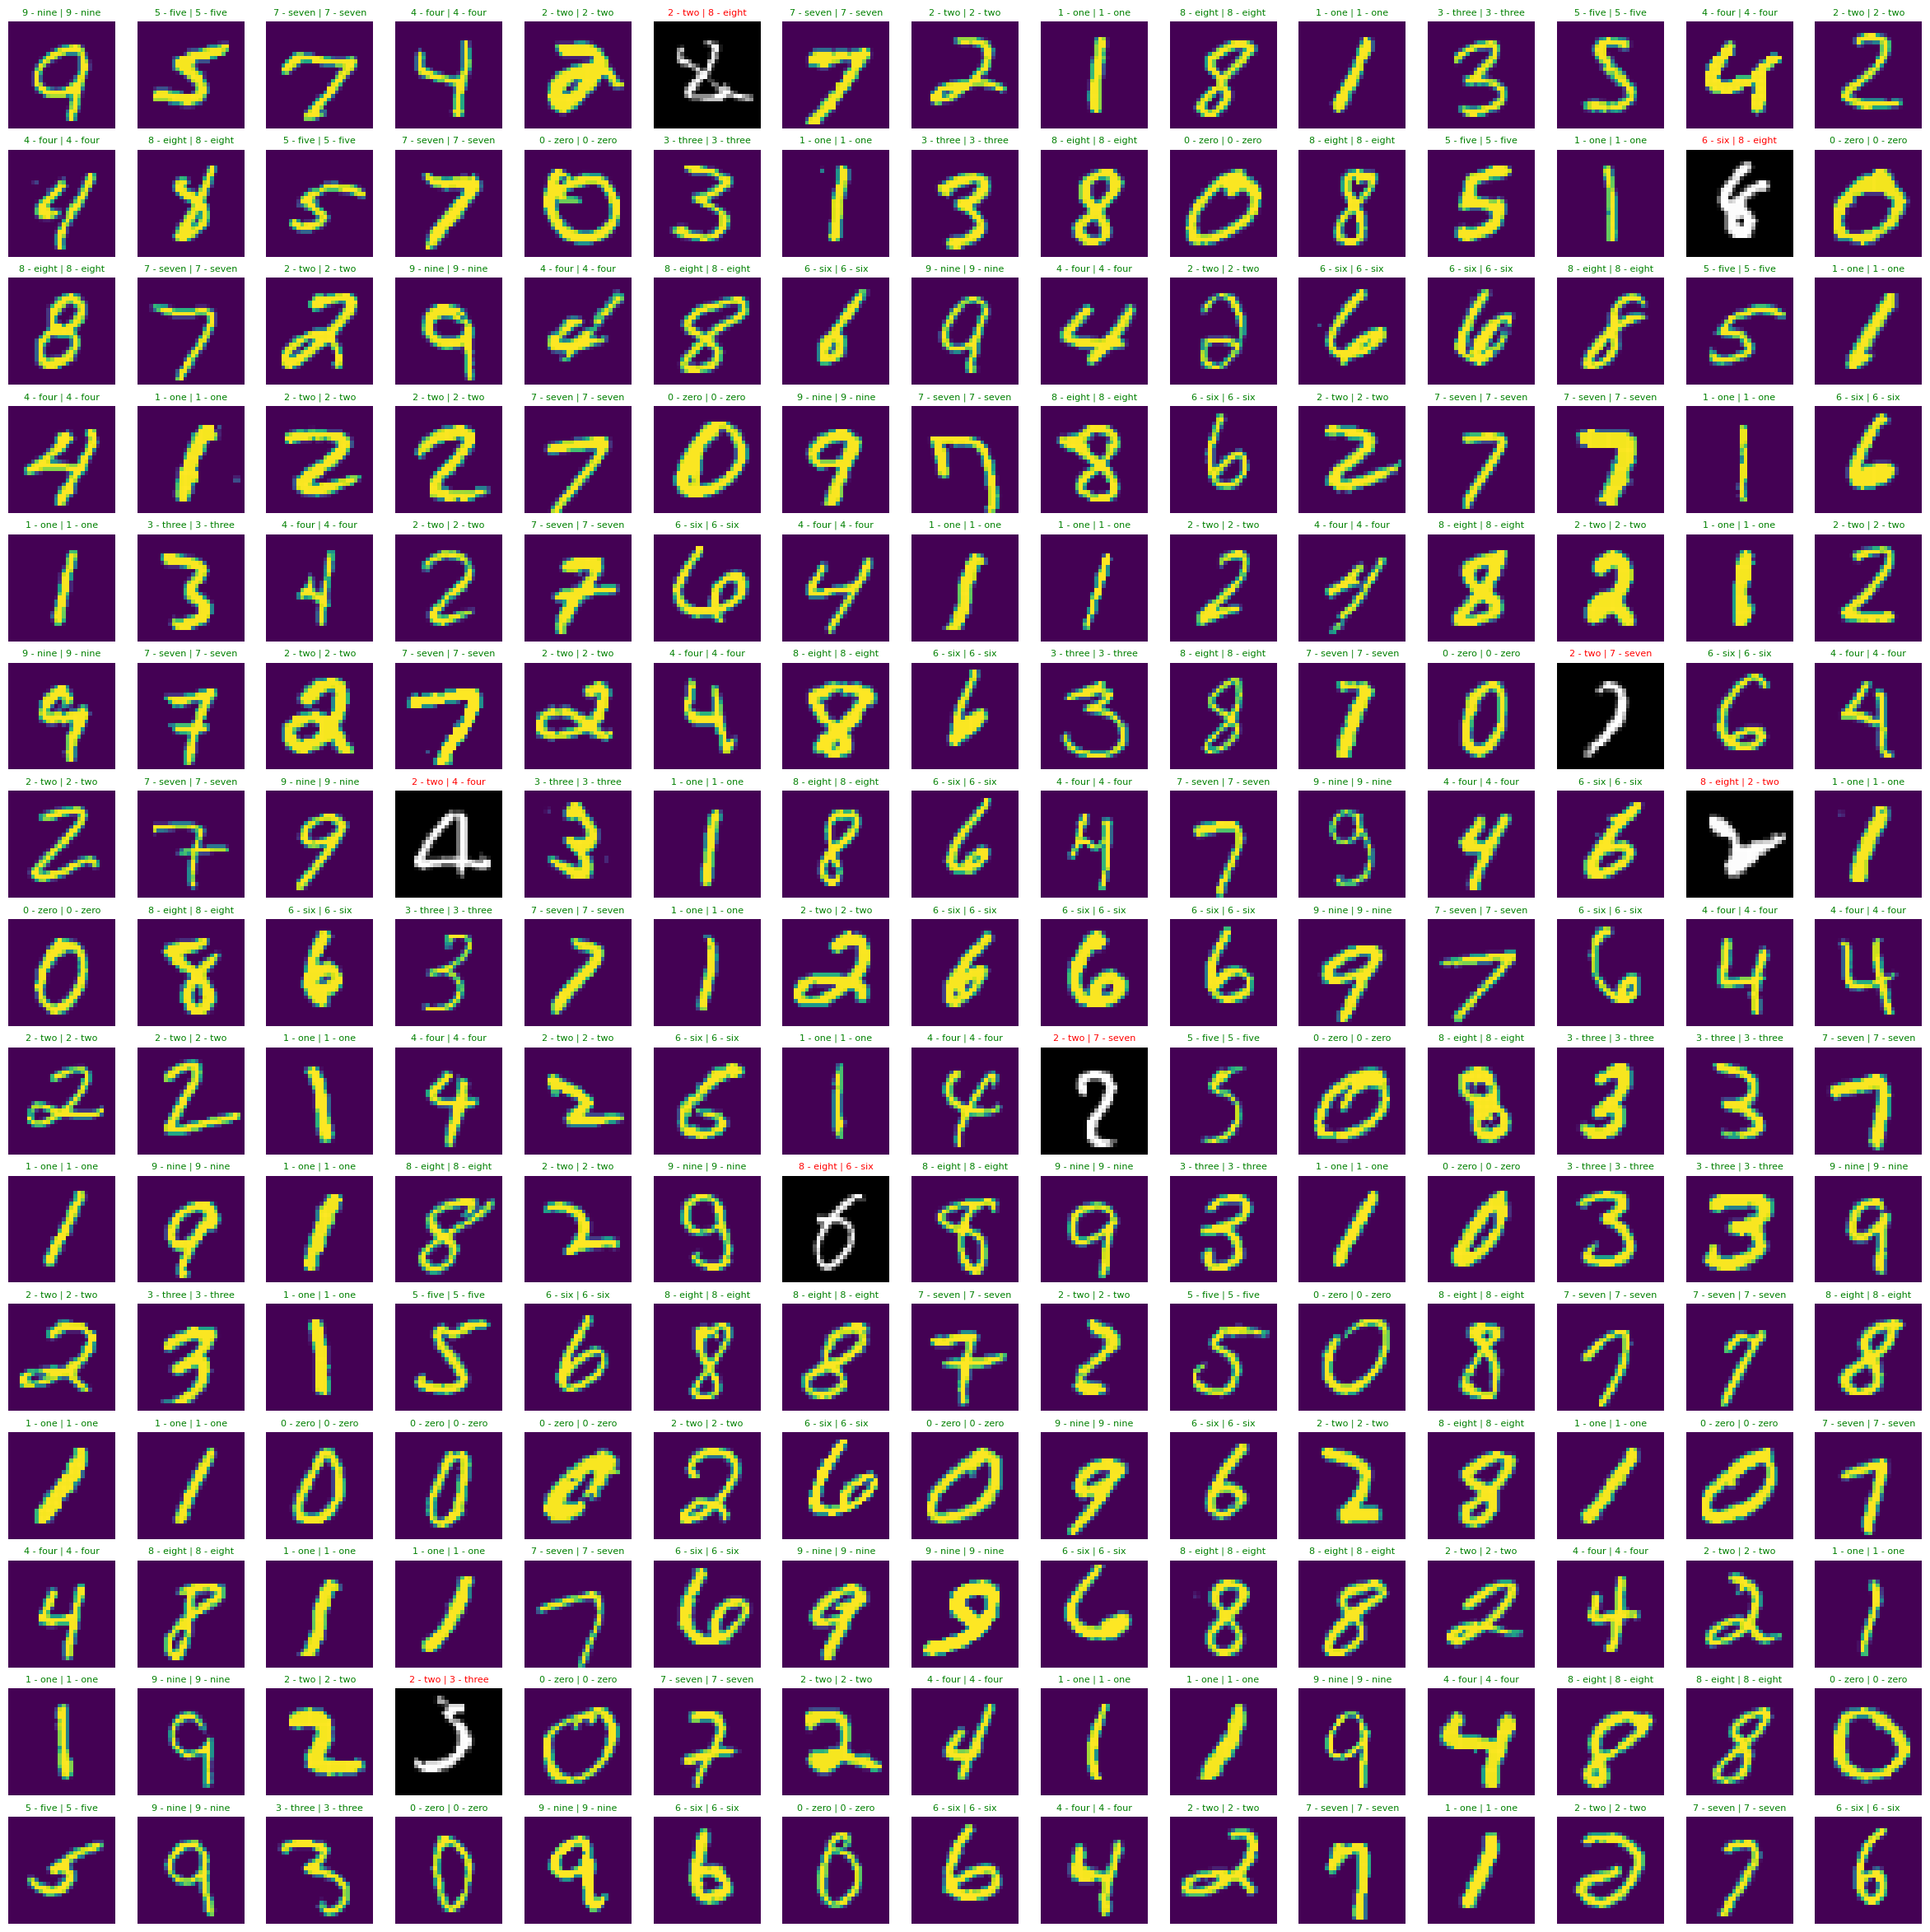

In [23]:
show_grid(row = 15, col = 15,model = model2,Cnn=1,test_data=test_data)

In [40]:
train_data = datasets.USPS(root = "data",
                      train = True ,
                      transform = ToTensor(),
                      download = True,)
test_data = datasets.USPS(root = "data",
                      train = False ,
                      transform = ToTensor(),
                      download = True,)
#classNames = test_data.classes
classNames
batch_size = 32
trainDataLoader2  = DataLoader(dataset = train_data ,batch_size = batch_size , shuffle = True )
testDataLoader2 = DataLoader(dataset = test_data , batch_size = batch_size , shuffle = False)

In [107]:
class three(nn.Module):
  def __init__(self):
    super().__init__()
    self.b1 = nn.Sequential(
        nn.Conv2d(in_channels = 1 , out_channels = 10 , kernel_size  = (3,3) ,stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 1),
    )
    self.b2 = nn.Sequential(
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 1),
     )
    self.b3 = self.b2 = nn.Sequential(
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 1),
     )
    self.b4 = self.b2 = nn.Sequential(
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.ReLU(),
        nn.Conv2d(in_channels = 10 , out_channels = 10 , kernel_size = (3,3) , stride = 1 , padding = 1 ),
        nn.MaxPool2d(kernel_size = (2,2) , stride = 2),
     )
    self.Classify = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features =10*3*3 , out_features = 10),
    )
  def forward(self,X):
    try :
      X1 = self.b1(X)
      #print(X1.shape)
      X2 = self.b2(X1)
      #print(X2.shape)
      X3 =  self.b3(X2)
      #print(X3.shape)
      X4 = self.b4(X3)
      #print(X4.shape)
      return self.Classify(X4)
    except Exception as  e:

      print(e)
      print(e.__traceback__.tb_lineno)
    return None

  def pred(self , X):
    self.eval()
    with torch.inference_mode():
      return self(X)


In [108]:
model3 = three()
loss_fn = nn.CrossEntropyLoss()

In [110]:
%%time
train(model = model3 , loss_fn = loss_fn , lr = 0.0001, epochs = 10 , trainDataLoader = trainDataLoader2 , testDataLoader = testDataLoader2)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

seen 0 / 7296
epoch 0 | train loss : 0.081073 , test loss : 0.315 | test accuracy 94.673058%
seen 0 / 7296
epoch 1 | train loss : 0.058498 , test loss : 0.277 | test accuracy 94.970680%
seen 0 / 7296
epoch 2 | train loss : 0.047741 , test loss : 0.267 | test accuracy 94.852058%
seen 0 / 7296
epoch 3 | train loss : 0.040743 , test loss : 0.253 | test accuracy 94.901657%
seen 0 / 7296
epoch 4 | train loss : 0.036043 , test loss : 0.255 | test accuracy 94.951263%
seen 0 / 7296
epoch 5 | train loss : 0.032213 , test loss : 0.258 | test accuracy 94.970680%
seen 0 / 7296
epoch 6 | train loss : 0.028934 , test loss : 0.260 | test accuracy 94.871468%
seen 0 / 7296
epoch 7 | train loss : 0.026255 , test loss : 0.255 | test accuracy 94.821869%
seen 0 / 7296
epoch 8 | train loss : 0.023755 , test loss : 0.260 | test accuracy 95.089294%
seen 0 / 7296
epoch 9 | train loss : 0.021430 , test loss : 0.268 | test accuracy 95.119484%
CPU times: user 17.2 s, sys: 169 ms, total: 17.3 s
Wall time: 18.9 s


correct : 95 , Wrong : 5


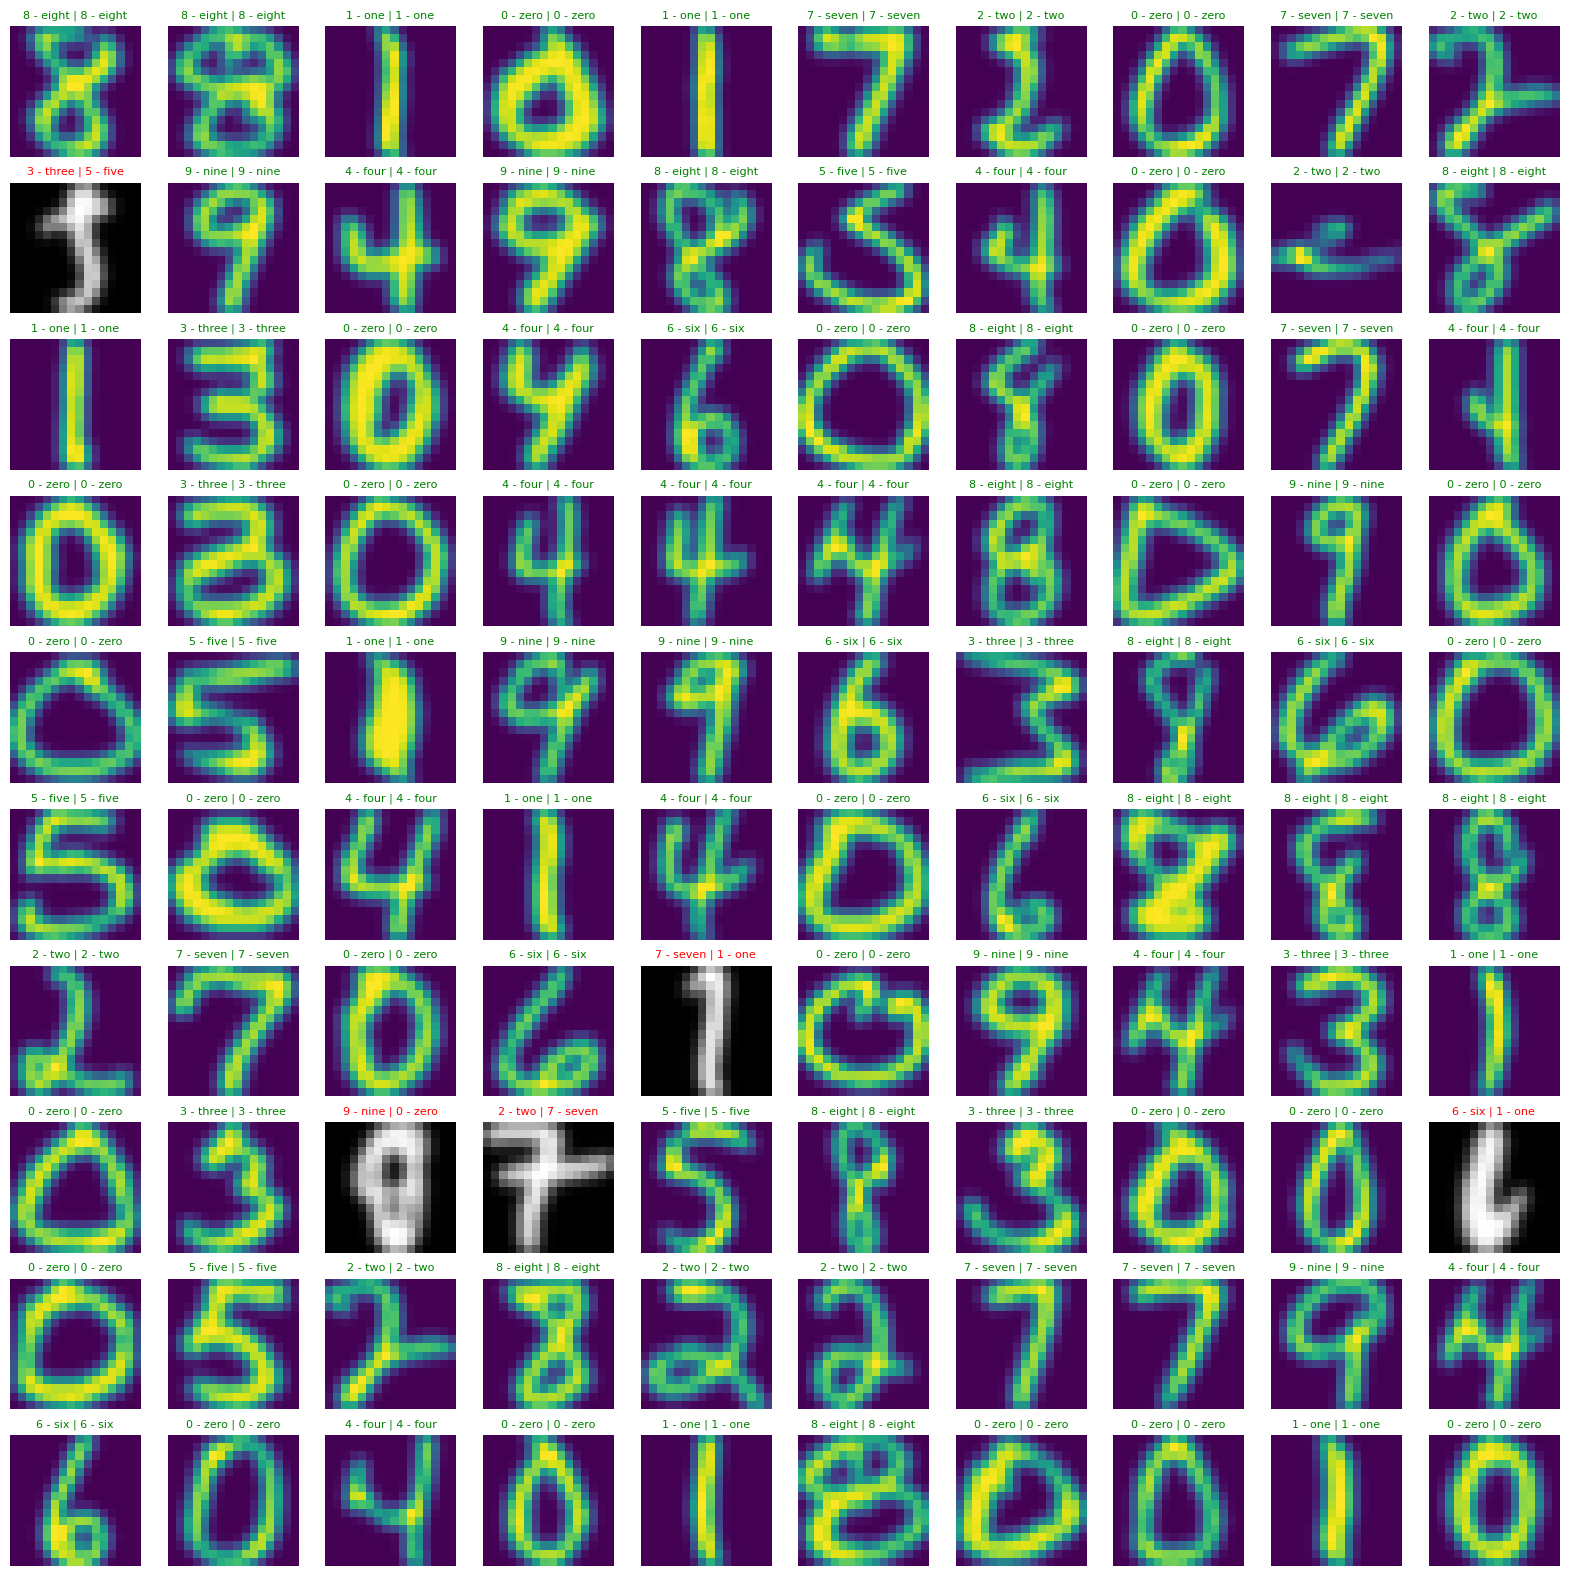

In [111]:
show_grid(model3,10,10,test_data,Cnn=1)